# 🐾 PetPal Emotion Classifier — Training
## Fine-tune `distilroberta-base` for 7-Class Emotion Classification

**⚠️ Run `preprocess_data.ipynb` FIRST** to generate `data/processed/train.csv` and `val.csv`.

**Model:** `distilbert/distilroberta-base`  
**Task:** Multi-class text classification (7 emotions)  
**Loss:** CrossEntropyLoss (via `AutoModelForSequenceClassification`)

| ID | Emotion | Labels Mapped From |
|---|---------|---|
| 0 | happy | admiration, amusement, approval, excitement, gratitude, joy, love, optimism, pride, relief, desire |
| 1 | calm | neutral, realization, caring |
| 2 | sad | sadness, grief, disappointment, remorse |
| 3 | angry | anger, annoyance, disgust, disapproval |
| 4 | anxious | fear, nervousness |
| 5 | stressed | embarrassment |
| 6 | confused | confusion, curiosity, surprise |

---
## Step 1 — Imports & Configuration

In [1]:
# Uncomment if needed
# !pip install torch transformers scikit-learn pandas numpy matplotlib seaborn accelerate

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
)
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
)
from torch.utils.data import Dataset

print("All imports successful ✅")

c:\Users\Taruni\Desktop\petpal\Pet_Pal\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


All imports successful ✅


In [3]:
# ── CONFIG ──
MODEL_NAME      = "distilbert/distilroberta-base"
NUM_LABELS      = 7
EPOCHS          = 1  # Reduced from 4 to 1 for CPU training speed
BATCH_SIZE      = 8  # Reduced batch size for CPU stability
LEARNING_RATE   = 2e-5
MAX_SEQ_LEN     = 128
SAVE_DIR        = "./emotion_model"
PROCESSED_DIR   = "./data/processed"
SEED            = 42

# Label names & Mappings
UI_LABEL_NAMES = ["happy", "calm", "sad", "angry", "anxious", "stressed", "confused"]
ID2LABEL       = {idx: name for idx, name in enumerate(UI_LABEL_NAMES)}
LABEL2ID       = {name: idx for idx, name in enumerate(UI_LABEL_NAMES)}

# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️  Device: {DEVICE}")

🖥️  Device: cpu


---
## Step 2 — Load Processed Data

In [4]:
# Load pre-processed train/val CSVs
train_df = pd.read_csv(os.path.join(PROCESSED_DIR, "train.csv"))
val_df   = pd.read_csv(os.path.join(PROCESSED_DIR, "val.csv"))

# CPU SPEEDUP: Use a sample if training on CPU to finish within 30-60 mins
if DEVICE == torch.device("cpu"):
    print("⚠️ CPU training detected. Subsetting to 20,000 samples for speed.")
    train_df = train_df.sample(20000, random_state=SEED)
    val_df   = val_df.sample(4000, random_state=SEED)

print(f"📂 Loaded processed data:")
print(f"   Train: {len(train_df):,} samples")
print(f"   Val:   {len(val_df):,} samples")
print(f"   Columns: {list(train_df.columns)}")

# Class distribution
print("\n📊 Training set class distribution:")
for idx, name in ID2LABEL.items():
    count = (train_df["label"] == idx).sum()
    print(f"   {idx} = {name:10s} → {count:,}")

train_df.head()

⚠️ CPU training detected. Subsetting to 20,000 samples for speed.
📂 Loaded processed data:
   Train: 20,000 samples
   Val:   4,000 samples
   Columns: ['text', 'ui_emotion', 'label']

📊 Training set class distribution:
   0 = happy      → 7,115
   1 = calm       → 6,276
   2 = sad        → 1,191
   3 = angry      → 3,137
   4 = anxious    → 373
   5 = stressed   → 180
   6 = confused   → 1,728


,text,ui_emotion,label
4622,I was trying to think of a better player to pi...,sad,2
135790,Because it was a terrible idea.,anxious,4
100556,My girlfriend always says “Them’s the rules.” ...,happy,0
23476,I don't see any shoes on his feet after he lan...,angry,3
161857,that is the saddest damn yogurt ive ever seen,sad,2


---
## Step 3 — PyTorch Dataset Class

In [5]:
class EmotionDataset(Dataset):
    """Simple PyTorch Dataset wrapping tokenized text + integer labels."""

    def __init__(self, texts, labels, tokenizer, max_len=MAX_SEQ_LEN):
        # Optimized: Dynamic padding (removed padding="max_length")
        self.encodings = tokenizer(
            list(texts),
            truncation=True,
            max_length=max_len,
            padding=False,    # Let data collator handle it
        )
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item


print("EmotionDataset class defined ✅")

EmotionDataset class defined ✅


---
## Step 4 — Load Tokenizer & Model

In [6]:
print(f"🤖 Loading tokenizer & model: {MODEL_NAME}")

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS,
    id2label=ID2LABEL,    # Map integer IDs to names (e.g., 0 → happy)
    label2id=LABEL2ID,    # Map names to integer IDs (e.g., happy → 0)
)
model.to(DEVICE)

print(f"Model loaded and moved to {DEVICE} ✅")
print(f"Model labels: {model.config.id2label}")

🤖 Loading tokenizer & model: distilbert/distilroberta-base


Loading weights: 100%|██████████| 101/101 [00:00<00:00, 586.68it/s, Materializing param=roberta.encoder.layer.5.output.dense.weight]             
RobertaForSequenceClassification LOAD REPORT from: distilbert/distilroberta-base
Key                         | Status     | 
----------------------------+------------+-
lm_head.bias                | UNEXPECTED | 
roberta.pooler.dense.bias   | UNEXPECTED | 
lm_head.layer_norm.bias     | UNEXPECTED | 
lm_head.dense.weight        | UNEXPECTED | 
roberta.pooler.dense.weight | UNEXPECTED | 
lm_head.dense.bias          | UNEXPECTED | 
lm_head.layer_norm.weight   | UNEXPECTED | 
classifier.dense.weight     | MISSING    | 
classifier.dense.bias       | MISSING    | 
classifier.out_proj.weight  | MISSING    | 
classifier.out_proj.bias    | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoi

Model loaded and moved to cpu ✅
Model labels: {0: 'happy', 1: 'calm', 2: 'sad', 3: 'angry', 4: 'anxious', 5: 'stressed', 6: 'confused'}


---
## Step 5 — Tokenize & Create Datasets

In [7]:
print("🔡 Tokenizing train & validation sets …")

train_dataset = EmotionDataset(
    train_df["text"].values,
    train_df["label"].values,
    tokenizer,
)
val_dataset = EmotionDataset(
    val_df["text"].values,
    val_df["label"].values,
    tokenizer,
)

print(f"Train samples: {len(train_dataset):,}")
print(f"Val samples:   {len(val_dataset):,}")
print("Tokenization complete ✅")

🔡 Tokenizing train & validation sets …
Train samples: 20,000
Val samples:   4,000
Tokenization complete ✅


---
## Step 6 — Configure & Start Training

In [8]:
def compute_metrics(eval_pred):
    """Compute macro-F1 for the Trainer evaluation loop."""
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    macro_f1 = f1_score(labels, preds, average="macro")
    return {"macro_f1": macro_f1}

# Optimized: Data collator for dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir="./emotion_training_output",
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="no", # Faster (skip saving middle checkpoints)
    load_best_model_at_end=False,
    logging_steps=100,
    seed=SEED,
    # Mixed precision usually only works on GPU
    fp16=torch.cuda.is_available(),
    # Use a simpler optimizer on CPU
    optim="adamw_torch",
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

print("Trainer configured with CPU optimizations ✅")

Trainer configured with CPU optimizations ✅


In [9]:
print("🚀 Starting training …\n")
trainer.train()

🚀 Starting training …



c:\Users\Taruni\Desktop\petpal\Pet_Pal\.venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch,Training Loss,Validation Loss,Macro F1
1,1.101973,1.108690,0.399222


TrainOutput(global_step=2500, training_loss=1.1878767211914063, metrics={'train_runtime': 3157.9204, 'train_samples_per_second': 6.333, 'train_steps_per_second': 0.792, 'total_flos': 162411232117440.0, 'train_loss': 1.1878767211914063, 'epoch': 1.0})

---
## Step 7 — Evaluation

In [10]:
# Run predictions on validation set
preds_output = trainer.predict(val_dataset)
preds = np.argmax(preds_output.predictions, axis=-1)
val_labels = val_df["label"].tolist()

# ── Macro F1 Score ──
macro_f1 = f1_score(val_labels, preds, average="macro")
print("=" * 60)
print(f"  ★  FINAL MACRO F1 SCORE:  {macro_f1:.4f}")
print("=" * 60)

c:\Users\Taruni\Desktop\petpal\Pet_Pal\.venv\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


  ★  FINAL MACRO F1 SCORE:  0.3992


In [11]:
# ── Classification Report ──
print("📋 Classification Report:\n")
print(classification_report(
    val_labels, preds,
    target_names=UI_LABEL_NAMES,
    digits=4,
))

📋 Classification Report:

              precision    recall  f1-score   support

       happy     0.6903    0.7461    0.7171      1410
        calm     0.5311    0.4992    0.5146      1250
         sad     0.4518    0.3504    0.3947       254
       angry     0.4852    0.5485    0.5149       629
     anxious     0.5385    0.0959    0.1628        73
    stressed     0.0000    0.0000    0.0000        34
    confused     0.4711    0.5114    0.4904       350

    accuracy                         0.5740      4000
   macro avg     0.4526    0.3931    0.3992      4000
weighted avg     0.5653    0.5740    0.5655      4000



c:\Users\Taruni\Desktop\petpal\Pet_Pal\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Taruni\Desktop\petpal\Pet_Pal\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Taruni\Desktop\petpal\Pet_Pal\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

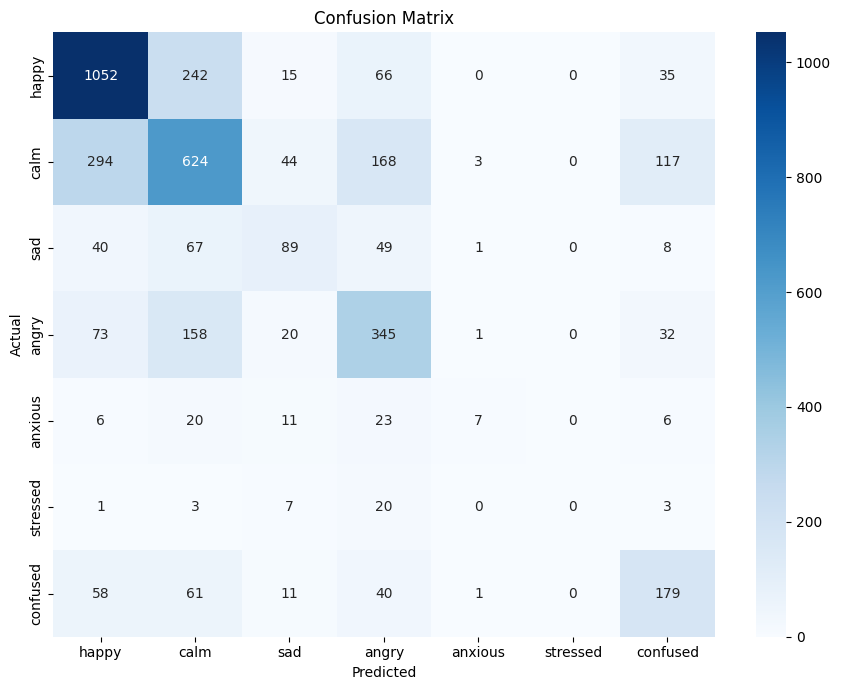

In [12]:
# ── Confusion Matrix Heatmap ──
cm = confusion_matrix(val_labels, preds)

plt.figure(figsize=(9, 7))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=UI_LABEL_NAMES,
    yticklabels=UI_LABEL_NAMES,
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

---
## Step 8 — Save Model & Tokenizer

In [13]:
os.makedirs(SAVE_DIR, exist_ok=True)
model.save_pretrained(SAVE_DIR)
tokenizer.save_pretrained(SAVE_DIR)

print(f"💾 Model & tokenizer saved → {SAVE_DIR}/")
print("\n✅ Done! The model now includes human-readable labels.")

Writing model shards: 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

💾 Model & tokenizer saved → ./emotion_model/

✅ Done! The model now includes human-readable labels.


---
## Step 9 — Quick Inference Test
The model now directly outputs emotion labels!

In [14]:
from transformers import pipeline

classifier = pipeline(
    "text-classification",
    model=SAVE_DIR,
    tokenizer=SAVE_DIR,
)

test_sentences = [
    "I'm so happy today, everything is going great!",
    "I feel really anxious about my exam tomorrow.",
    "This makes me so angry, I can't believe it.",
    "I feel calm and peaceful right now.",
    "I'm really sad about losing my pet.",
]

print("🧪 Inference Test:\n")
for sentence in test_sentences:
    res = classifier(sentence)[0]
    print(f"  \"{sentence}\"")
    print(f"  → {res['label']} ({res['score']:.3f})\n")

Loading weights: 100%|██████████| 105/105 [00:00<00:00, 457.20it/s, Materializing param=roberta.encoder.layer.5.output.dense.weight]             


🧪 Inference Test:

  "I'm so happy today, everything is going great!"
  → happy (0.938)

  "I feel really anxious about my exam tomorrow."
  → sad (0.369)

  "This makes me so angry, I can't believe it."
  → angry (0.336)

  "I feel calm and peaceful right now."
  → happy (0.602)

  "I'm really sad about losing my pet."
  → sad (0.668)

